In [1]:
!pip install omegaconf

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from collections import OrderedDict


# Function to create the rotation matrix for RoPE embeddings
def generate_rotation_matrix(seq_length, embed_dim):
    # [INSTRUCTION] Complete this function to generate a rotation matrix for RoPE embeddings.
    # The matrix rotates queries and keys based on sequence position and embedding dimension.
    # Hint: Consider using the provided exponential decay formula for theta and apply trigonometric rotations.
    R = torch.zeros((seq_length, embed_dim, embed_dim), requires_grad=False)

    positions = torch.arange(1, seq_length + 1).unsqueeze(1)
    # Create matrix theta (shape: context_len  x embedding_dim // 2)
    slice_i = torch.arange(0, embed_dim // 2)

    theta = 10000. ** (-2.0 * (slice_i.float()) / embed_dim)
    m_theta = positions * theta

    # Create sin and cos values
    cos_values = torch.cos(m_theta)
    sin_values = torch.sin(m_theta)

    # Populate the rotary matrix R using 2D slicing
    R[:, 2*slice_i, 2*slice_i] = cos_values
    R[:, 2*slice_i, 2*slice_i+1] = -sin_values
    R[:, 2*slice_i+1, 2*slice_i] = sin_values
    R[:, 2*slice_i+1, 2*slice_i+1] = cos_values
    return R

In [3]:
# Custom RMS Normalization layer
class RMSNorm(nn.Module):
    def __init__(self, layer_dims, epsilon=1e-8):
        super().__init__()
        self.register_parameter("gamma", nn.Parameter(torch.ones(layer_dims)))
        self.epsilon = epsilon

    def forward(self, tensor_input):
        # [INSTRUCTION] Complete the forward method to normalize the input tensor using RMSNorm.
        # Compute the root mean square of the tensor values and use it to normalize the tensor_input.
        # Consider dimensions appropriately for batch processing and do not forget to add epsilon for numerical stability.
        mean_rms = torch.norm(tensor_input, dim=tuple(range(1, len(tensor_input.shape))), keepdim=True)

        # Apply RMS normalization with epsilon for stability
        std_rms = torch.sqrt(mean_rms**2 + self.epsilon)
        normalized = tensor_input / std_rms

        # Apply learnable scale factor (gamma)
        return normalized * self.gamma.to(normalized.device)

In [4]:
import math

# Attention head with RoPE embeddings and masking
class AttentionHeadWithRoPE(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize linear layers for queries, keys, and values.
        # Each should transform input data to the same embedding dimensionality, and none should include bias terms.
        self.query_linear = nn.Linear(params['embed_dim'], params['embed_dim'], bias=False)
        self.key_linear = nn.Linear(params['embed_dim'], params['embed_dim'], bias=False)
        self.value_linear = nn.Linear(params['embed_dim'], params['embed_dim'], bias=False)

        # [INSTRUCTION] Retrieve the rotation matrix generated for RoPE embeddings, ensuring it is moved to the correct device.
        self.register_buffer('rotation_matrix', self.params['rotation_matrix'].to(params['device']))

    def forward(self, data_input, return_attention=False):
        batch_size, seq_len, embed_dim = data_input.shape
        # [INSTRUCTION] Transform the input data into queries, keys, and values using the respective linear layers.
        queries = self.query_linear(data_input)
        keys = self.key_linear(data_input)
        values = self.value_linear(data_input)

        # [INSTRUCTION] Apply the RoPE rotation to both queries and keys. Think about the tensor shapes for matrix multiplication.
        queries = torch.bmm(queries, self.rotation_matrix)
        keys = torch.bmm(keys, self.rotation_matrix)

        # [INSTRUCTION] Compute scaled dot-product attention. Remember to handle masking if 'return_attention' is true.
        # Optionally return attention weights for visualization or debugging.
        attention_scores = torch.bmm(queries, keys.transpose(1, 2))
        attention_scores = attention_scores / math.sqrt(queries.size(-1))
        if return_attention:
            return attention_scores

        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_output = torch.bmm(attention_weights, values)
        attention_output = attention_output.transpose(1, 2)
        attention_output = attention_output.reshape(batch_size, seq_len, embed_dim)
        return attention_output


In [5]:
# Multi-head attention module
class MultiHeadAttention(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize multiple attention heads.
        # Create a ModuleList of AttentionHeadWithRoPE instances, one for each attention head specified in 'params'.
        # Initialize attention heads here
        self.attention_heads = nn.ModuleList([AttentionHeadWithRoPE(params) for _ in range(params['num_heads'])])


        # [INSTRUCTION] Define an output linear transformation that combines the outputs of all heads.
        # This linear layer should project from the concatenated dimension back to the embedding size.
        print(params['num_heads'])
        self.output_linear = nn.Linear(params['embed_dim'] * params['num_heads'], params['embed_dim'])

        # [INSTRUCTION] Add dropout for regularization after combining the outputs of the attention heads.
        self.dropout = nn.Dropout(params['dropout'])

    def forward(self, data_input):
        # [INSTRUCTION] Compute the output for each attention head and concatenate them along the last dimension.
        # Compute the output for each attention head
        head_outputs = []
        for head in self.attention_heads:
            head_output = head(data_input)
            head_outputs.append(head_output)

        # Concatenate attention head outputs
        attention_output = torch.cat(head_outputs, dim=-1)

        # Apply the output linear transformation and dropout
        output = self.dropout(self.output_linear(attention_output))

        return output

In [6]:

# Swish-Gated Linear Unit (SiGLU) activation function
class SwishGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = nn.Parameter(torch.ones(1))

    def forward(self, data_input):
        # [INSTRUCTION] Implement the SwishGLU activation function.
        # The function should use a gated mechanism with a swish activation to modulate the input data.
        gate = torch.nn.functional.silu(self.linear_gate(data_input))  # Apply swish to gate output
        activation = self.linear(data_input)
        output = gate * activation + (1 - gate) * self.beta * data_input  # Gated linear modulation
        return output

In [7]:
# Transformer block consisting of attention and feedforward layers
class LLamaBlock(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Define the RMS normalization layers 'norm1' and 'norm2'.
        # Each should be initialized with appropriate dimensions based on sequence length and embedding size.
        self.norm1 = RMSNorm(params['embed_dim'])
        self.norm2 = RMSNorm(params['embed_dim'])

        # [INSTRUCTION] Initialize the attention head using the AttentionHeadWithRoPE class with given parameters.
        # Actually we should use multihead attention, I suppose
        self.attention = MultiHeadAttention(params)

        # [INSTRUCTION] Define a feedforward network consisting of a linear layer followed by a SwishGLU activation.
        # Ensure the dimensionality matches the embedding size defined in params.
        self.ff_linear1 = nn.Linear(params['embed_dim'], params['embed_dim'])
        self.ff_activation = SwishGLU(params['embed_dim'])
        self.ff_linear2 = nn.Linear(params['embed_dim'], params['embed_dim'])

    def forward(self, data_input):
        # [INSTRUCTION] Implement the forward pass integrating normalization, attention, and feedforward layers.
        # Include residual connections for the attention and feedforward blocks.
        # Hint: Remember to apply normalization before and after the attention, as well as before the feedforward network.
        # Residual connection with norm1
        norm1_output = self.norm1(data_input)

        # Attention block with residual connection
        attention_output = self.attention(norm1_output)
        attention_output = data_input + attention_output  # Residual connection

        # Second normalization with norm2
        norm2_output = self.norm2(attention_output)

        # Feedforward network with residual connection
        ff1_output = self.ff_linear1(norm2_output)
        ff_activation_output = self.ff_activation(ff1_output)
        ff_output = self.ff_linear2(ff_activation_output)
        output = attention_output + ff_output  # Residual connection

        return output

In [8]:
# LLaMA-like language model
class LLama(nn.Module):
    def __init__(self, params):
        super().__init__()
        self.params = params
        # [INSTRUCTION] Initialize the embedding layer for the input tokens.
        self.embedding = nn.Embedding(params['vocab_size'], params['embed_dim'])

        self.transformer_blocks = nn.ModuleDict()
        for _ in range(params['transformer_blocks']):
            block_name = f"block_{_}"
            self.transformer_blocks[block_name] = LLamaBlock(params)

        # [INSTRUCTION] Define the final linear transformation layers.
        # This should include a linear layer to match the embedding dimension, a SwishGLU activation, and a final linear layer to map back to the vocabulary size.
        self.final_linear1 = nn.Linear(params['embed_dim'], params['ff_dim'])
        self.final_activation = SwishGLU(params['ff_dim'])
        self.final_linear2 = nn.Linear(params['ff_dim'], params['vocab_size'])

        # Optionally print the total number of parameters in the model
        print("Model parameters:", sum([p.numel() for p in self.parameters()]))

    def forward(self, input_ids, target_ids=None):
        # [INSTRUCTION] Implement the forward pass of the model.
        # Embed the input_ids, process them through the LLama_blocks, and apply the final linear transformations.
        # If target_ids are provided, compute and return the cross-entropy loss along with the logits.
        logits = None
        loss = None
        embed = self.embedding(input_ids)

        for block_name, block in self.transformer_blocks.items():
            embed = block(embed)

        logits = self.final_linear2(self.final_activation(self.final_linear1(embed)))
        if target_ids is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), target_ids.view(-1))

        return logits, loss

In [9]:
!pip install gdown
!gdown 1S7n5n6A-2MDa8dqCOl4l1VmcYnAW0i9u

Downloading...
From: https://drive.google.com/uc?id=1S7n5n6A-2MDa8dqCOl4l1VmcYnAW0i9u
To: /content/input.txt
100% 5.46M/5.46M [00:00<00:00, 55.0MB/s]


In [10]:
# Data preprocessing function
def prepare_data(file_path):
    # [INSTRUCTION] Open the file and read the text. Then create a list of unique characters and build two dictionaries:
    # one to convert characters to indices and another from indices to characters.
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()

    unique_chars = list(set(text))
    char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
    idx_to_char = {idx: char for idx, char in enumerate(unique_chars)}
    vocabulary_size = len(unique_chars)

    # [INSTRUCTION] Convert the entire text into a tensor of indices corresponding to the characters.
    data_tensor = torch.tensor([char_to_idx[char] for char in text])

    return data_tensor, vocabulary_size

# Function to create training batches
def batch_generator(data, split, batch_size, seq_len, params):
    # [INSTRUCTION] Split the data into training, validation, and test sets based on the provided ratios.
    # Consider using 80% of data for training, 10% for validation, and 10% for testing.
    train_size = int(0.8 * len(data))
    val_size = int(0.1 * len(data))
    test_size = len(data) - train_size - val_size

    if split == 'train':
        dataset = data[:train_size]
    elif split == 'validation':
        dataset = data[train_size:train_size+val_size]
    else:
        dataset = data[train_size+val_size:]

    # [INSTRUCTION] Generate random starting points for each batch and construct input and target sequences.
    # The target sequence for each input is simply the input sequence shifted by one position.
    # Generate random batch start indices and construct input and target sequences here
    batch_start_indices = torch.randint(0, len(dataset) - seq_len - 1, (batch_size,))
    input_sequences = []
    target_sequences = []
    for start_idx in batch_start_indices:
        input_sequence = dataset[start_idx:start_idx+seq_len]
        target_sequence = dataset[start_idx+1:start_idx+seq_len+1]
        input_sequences.append(input_sequence)
        target_sequences.append(target_sequence)

    input_sequences = torch.stack(input_sequences)
    target_sequences = torch.stack(target_sequences)

    return input_sequences, target_sequences

In [11]:
# Function to evaluate model loss
@torch.no_grad()
def eval_loss(model, dataset, params):
    results = {}
    model.eval()
    for split in ["train", "validation"]:
        batch_losses = []
        for _ in range(10):
            input_batch, target_batch = batch_generator(dataset, split, params['training_batch'], params['sequence_length'], params)
            input_batch = input_batch.to(device)
            target_batch = target_batch.to(device)
            _, batch_loss = model(input_batch, target_batch)
            batch_losses.append(batch_loss.item())
        results[split] = np.mean(batch_losses)
    model.train()
    return results

In [12]:
# Training loop
import time
import pandas as pd
def train_model(model, optimizer, dataset, params, scheduler=None):
    all_losses = []
    start = time.time()
    for epoch in range(params['training_epochs']):
        optimizer.zero_grad()
        input_batch, target_batch = batch_generator(dataset, 'train', params['training_batch'], params['sequence_length'], params)

        input_batch = input_batch.to(device)
        target_batch = target_batch.to(device)
        _, batch_loss = model(input_batch, target_batch)
        batch_loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()

        if (epoch + 1) % params['logging_frequency'] == 0:
            time_elapsed = time.time() - start
            evaluation_result = eval_loss(model, dataset, params)
            all_losses.append(evaluation_result)
            print(
                f"Epoch {epoch + 1}/{params['training_epochs']} | "
                f"Validation Loss: {evaluation_result['validation']:.4f} | "
                f"Time: {time_elapsed:.2f}s"
            )
            start = time.time()
            if scheduler:
                print("lr: ", scheduler.get_lr())

    print("Final Validation Loss: ", all_losses[-1]['validation'])
    return pd.DataFrame(all_losses).plot()

Using GPU for training.
8
8
8
8
8
8
Model parameters: 3617250
Epoch 1/100 | Validation Loss: 4.3903 | Time: 2.27s
Epoch 2/100 | Validation Loss: 4.2317 | Time: 0.11s
Epoch 3/100 | Validation Loss: 4.0943 | Time: 0.12s
Epoch 4/100 | Validation Loss: 3.9265 | Time: 0.10s
Epoch 5/100 | Validation Loss: 3.8055 | Time: 0.14s
Epoch 6/100 | Validation Loss: 3.6950 | Time: 0.12s
Epoch 7/100 | Validation Loss: 3.5748 | Time: 0.14s
Epoch 8/100 | Validation Loss: 3.4554 | Time: 0.15s
Epoch 9/100 | Validation Loss: 3.3505 | Time: 0.12s
Epoch 10/100 | Validation Loss: 3.2478 | Time: 0.17s
Epoch 11/100 | Validation Loss: 3.1907 | Time: 0.12s
Epoch 12/100 | Validation Loss: 3.1779 | Time: 0.06s
Epoch 13/100 | Validation Loss: 3.1250 | Time: 0.07s
Epoch 14/100 | Validation Loss: 3.0681 | Time: 0.09s
Epoch 15/100 | Validation Loss: 3.0381 | Time: 0.09s
Epoch 16/100 | Validation Loss: 2.9896 | Time: 0.10s
Epoch 17/100 | Validation Loss: 3.0031 | Time: 0.06s
Epoch 18/100 | Validation Loss: 2.9667 | Time:

<Axes: >

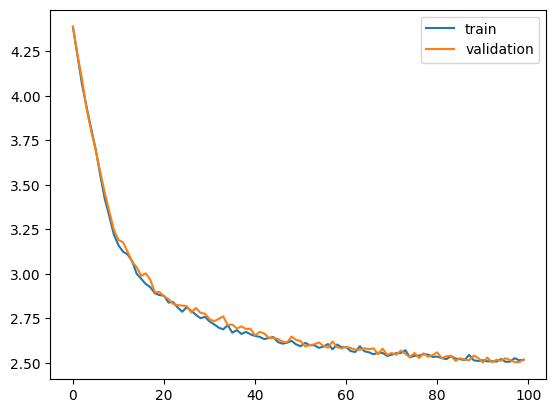

In [13]:
# Load and process the dataset
data_path = "./input.txt"
dataset, vocab_size = prepare_data(data_path)

# Configuration for the language model
MODEL_PARAMS = {
    # Write here model confiugraiton as in the homework file.
    'vocab_size': vocab_size,
    'embed_dim': 128,
    'sequence_length': 64,
    'training_batch': 64,
    'training_epochs': 100,
    'logging_frequency': 1,
    'num_heads': 8,
    'transformer_blocks': 6,
    'ff_dim': 128,
    'dropout': 0.1,
    'rotation_matrix': generate_rotation_matrix(64, 128),
}



# Check GPU availability and set device
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using GPU for training.")
    MODEL_PARAMS['device'] = 'cuda'
else:
    device = torch.device('cpu')
    print("GPU not found, using CPU for training.")
    MODEL_PARAMS['device'] = 'cpu'

# Create the language model
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model = LLama(MODEL_PARAMS).to(device)

# Move the dataset to the selected device
dataset = dataset.to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Start training
train_model(model, optimizer, dataset, MODEL_PARAMS)

## Task 2

### Increase the model parameters

16
16
16
16
16
16
16
16
16
16
16
16
Model parameters: 53599848
Epoch 1/100 | Validation Loss: 4.2228 | Time: 0.71s
Epoch 2/100 | Validation Loss: 3.9081 | Time: 0.81s
Epoch 3/100 | Validation Loss: 3.6473 | Time: 0.61s
Epoch 4/100 | Validation Loss: 3.5180 | Time: 0.62s
Epoch 5/100 | Validation Loss: 3.3013 | Time: 0.62s
Epoch 6/100 | Validation Loss: 3.2297 | Time: 0.63s
Epoch 7/100 | Validation Loss: 3.1426 | Time: 0.63s
Epoch 8/100 | Validation Loss: 3.0291 | Time: 0.65s
Epoch 9/100 | Validation Loss: 3.0081 | Time: 0.63s
Epoch 10/100 | Validation Loss: 2.9455 | Time: 0.66s
Epoch 11/100 | Validation Loss: 2.9586 | Time: 0.62s
Epoch 12/100 | Validation Loss: 2.9037 | Time: 0.62s
Epoch 13/100 | Validation Loss: 2.8770 | Time: 0.63s
Epoch 14/100 | Validation Loss: 2.8822 | Time: 0.62s
Epoch 15/100 | Validation Loss: 2.8591 | Time: 0.62s
Epoch 16/100 | Validation Loss: 2.8091 | Time: 0.62s
Epoch 17/100 | Validation Loss: 2.8310 | Time: 0.62s
Epoch 18/100 | Validation Loss: 2.7991 | Time

<Axes: >

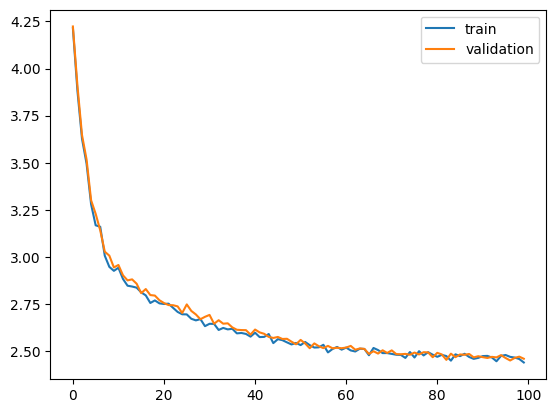

In [14]:
"""
Modify the model configuration to increase the number of parameters by adjusting the number
of attention heads, embedding size, and transformer blocks. Document the changes and the new
number of parameters.
"""
MODEL_PARAMS['num_heads']=16
MODEL_PARAMS['embed_dim']=256
MODEL_PARAMS['transformer_blocks']=12
MODEL_PARAMS['rotation_matrix'] = generate_rotation_matrix(64, 256)

# Create the language model
if torch.cuda.device_count() > 1:
    print(f"Distributing training across {torch.cuda.device_count()} GPUs.")
    model = nn.DataParallel(LLama(MODEL_PARAMS)).to(device)
else:
    model = LLama(MODEL_PARAMS).to(device)

# Create the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Start training
train_model(model, optimizer, dataset, MODEL_PARAMS)


**As we can see, increasing embedding dimensionality, number of heads and number of transformer blocks two times has changed the validation loss significantly. My assumption is that the number of paramerers is still not enough to achieve good performance. Unfortunately, it requires a lot of computational resources to test whether it is so.**